# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)
len(train_X[0])

3072

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут хранить через специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])
print(train_X.shape)

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!
(9000, 3072)


Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [163]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [164]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

In [165]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch

loss_history, train_history, val_history = trainer.fit()

Loss: 2.288635, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291292, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273437, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274325, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307071, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248588, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243216, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276891, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.224580, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228907, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294124, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320585, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.247555, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228948, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336594, Train acc

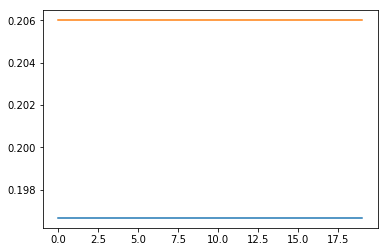

In [166]:
plt.plot(train_history)
plt.plot(val_history)

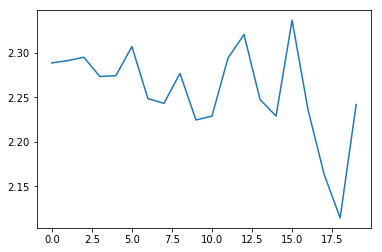

In [167]:
plt.plot(loss_history)

In [ ]:
class Layer:
    def forward(self, x):
        result = ... # промежуточные вычисления
        self.x = x # сохраняем значения, которые нам
                   # понадобятся при обратном проходе
        return result
    
    def backward(self, grad):
        dx = ... # используем сохраненные значения, чтобы 
        dw = ... # вычислить градиент по x и по w
        self.w.grad += dw # аккумулируем градиент dw
        return dx

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [168]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.310747, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.313867, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295066, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288843, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300448, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253576, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265556, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294278, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273850, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274480, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240370, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281288, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.174645, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271071, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309541, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245008, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [169]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.313617, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295766, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286736, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294125, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263854, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273617, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267116, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292113, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182253, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.214963, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233842, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264720, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.241952, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262304, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324282, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [170]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.317987, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306581, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305195, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.265284, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.285221, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.270452, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.248331, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.236890, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.163444, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.107823, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.291701, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.070856, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.100959, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.065637, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.848613, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.285651, Train acc

Loss: 0.701794, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.734321, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.796330, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.737030, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.686887, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.635966, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.614587, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.731655, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.735147, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.673597, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.707191, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.651742, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.704507, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.756157, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.692481, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [171]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = 300, reg = 1e-5)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.304923, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.259968, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.107075, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.150258, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.759947, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.602412, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 1.995647, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.882987, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.911925, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.523741, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.564826, Train accuracy: 0.933333, val accuracy: 0.066667
Loss: 0.281200, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.045934, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.006373, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.002002, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.002549, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [189]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2, 5e-2, 1e-1]
reg_strength = [1e-3,5e-3,1e-2]
learning_rate_decay = [0.8, 0.9, 0.99]
hidden_layer_size = [100, 200, 300]
momentum = [0.8, 0.85, 0.9]
epoch = 25
batch = 50

best_parameters = (-1, 0, 0, 0, 0, 0 ,0)
for laysize in hidden_layer_size:
    for decay in learning_rate_decay:
        for moment in momentum:
            for reg in reg_strength:
                for rate in learning_rates:
                    print(f'Current parameters are {(batch, epoch, laysize, decay, moment, reg, rate)}')
                    model = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = laysize, reg = reg)
                    dataset = Dataset(train_X, train_y, val_X, val_y)
                    trainer = Trainer(model, dataset, MomentumSGD(moment), learning_rate=rate, num_epochs=epoch, batch_size=batch, learning_rate_decay = decay)
                    loss_history, train_history, val_history = trainer.fit()
                    if best_parameters[0] < val_history[len(val_history)-1]:
                        best_parameters = (val_history[len(val_history)-1], batch, epoch, laysize, decay, moment, reg, rate)
    print(f'Best parameters for now are {best_parameters}')

Current parameters are (50, 25, 100, 0.8, 0.8, 0.001, 0.01)
Loss: 2.207475, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269332, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250819, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311298, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.249418, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.141365, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.175032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.207592, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.127413, Train accuracy: 0.202222, val accuracy: 0.214000
Loss: 2.191392, Train accuracy: 0.208667, val accuracy: 0.214000
Loss: 2.259724, Train accuracy: 0.213333, val accuracy: 0.217000
Loss: 2.058123, Train accuracy: 0.217556, val accuracy: 0.224000
Loss: 2.126340, Train accuracy: 0.221111, val accuracy: 0.228000
Loss: 2.101632, Train accuracy

Loss: 1.195795, Train accuracy: 0.710778, val accuracy: 0.685000
Loss: 1.358627, Train accuracy: 0.709667, val accuracy: 0.683000
Loss: 0.933965, Train accuracy: 0.711111, val accuracy: 0.684000
Current parameters are (50, 25, 100, 0.8, 0.8, 0.005, 0.1)
Loss: 2.057649, Train accuracy: 0.284556, val accuracy: 0.294000
Loss: 1.707413, Train accuracy: 0.500778, val accuracy: 0.509000
Loss: 1.394027, Train accuracy: 0.580111, val accuracy: 0.580000
Loss: 1.319346, Train accuracy: 0.658556, val accuracy: 0.655000
Loss: 1.349351, Train accuracy: 0.689889, val accuracy: 0.670000
Loss: 1.275232, Train accuracy: 0.721667, val accuracy: 0.690000
Loss: 1.403869, Train accuracy: 0.718889, val accuracy: 0.694000
Loss: 1.235619, Train accuracy: 0.741222, val accuracy: 0.713000
Loss: 1.153896, Train accuracy: 0.749444, val accuracy: 0.705000
Loss: 1.215325, Train accuracy: 0.766889, val accuracy: 0.731000
Loss: 1.215047, Train accuracy: 0.763667, val accuracy: 0.732000
Loss: 1.147562, Train accuracy:

Loss: 2.081304, Train accuracy: 0.277444, val accuracy: 0.280000
Loss: 1.864080, Train accuracy: 0.277667, val accuracy: 0.280000
Loss: 2.098259, Train accuracy: 0.277556, val accuracy: 0.281000
Loss: 2.065362, Train accuracy: 0.277889, val accuracy: 0.281000
Loss: 2.042457, Train accuracy: 0.278000, val accuracy: 0.282000
Loss: 2.029123, Train accuracy: 0.278111, val accuracy: 0.282000
Current parameters are (50, 25, 100, 0.8, 0.85, 0.001, 0.05)
Loss: 2.080575, Train accuracy: 0.255222, val accuracy: 0.259000
Loss: 1.626003, Train accuracy: 0.424444, val accuracy: 0.432000
Loss: 1.228365, Train accuracy: 0.575222, val accuracy: 0.575000
Loss: 1.278293, Train accuracy: 0.631333, val accuracy: 0.616000
Loss: 1.217757, Train accuracy: 0.658111, val accuracy: 0.647000
Loss: 1.552031, Train accuracy: 0.705111, val accuracy: 0.688000
Loss: 0.937569, Train accuracy: 0.709889, val accuracy: 0.674000
Loss: 0.974067, Train accuracy: 0.731667, val accuracy: 0.708000
Loss: 0.943845, Train accurac

Loss: 1.218989, Train accuracy: 0.790556, val accuracy: 0.739000
Loss: 1.331140, Train accuracy: 0.790778, val accuracy: 0.748000
Loss: 1.100055, Train accuracy: 0.792111, val accuracy: 0.751000
Loss: 1.215780, Train accuracy: 0.795000, val accuracy: 0.739000
Loss: 1.114352, Train accuracy: 0.795000, val accuracy: 0.743000
Loss: 0.924514, Train accuracy: 0.795333, val accuracy: 0.742000
Loss: 1.113080, Train accuracy: 0.796222, val accuracy: 0.745000
Loss: 1.043088, Train accuracy: 0.796222, val accuracy: 0.748000
Loss: 1.143772, Train accuracy: 0.796000, val accuracy: 0.747000
Current parameters are (50, 25, 100, 0.8, 0.85, 0.01, 0.01)
Loss: 2.142873, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212318, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.198673, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.190837, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240118, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244050, Train accuracy

Loss: 0.701743, Train accuracy: 0.808000, val accuracy: 0.753000
Loss: 0.839043, Train accuracy: 0.814000, val accuracy: 0.742000
Loss: 0.709614, Train accuracy: 0.816778, val accuracy: 0.746000
Loss: 0.783485, Train accuracy: 0.817222, val accuracy: 0.754000
Loss: 0.728307, Train accuracy: 0.817778, val accuracy: 0.751000
Loss: 0.579749, Train accuracy: 0.822222, val accuracy: 0.751000
Loss: 0.817571, Train accuracy: 0.821444, val accuracy: 0.751000
Loss: 0.593457, Train accuracy: 0.820889, val accuracy: 0.757000
Loss: 0.637088, Train accuracy: 0.822222, val accuracy: 0.752000
Loss: 0.908606, Train accuracy: 0.822556, val accuracy: 0.751000
Loss: 0.911239, Train accuracy: 0.824778, val accuracy: 0.752000
Loss: 0.769231, Train accuracy: 0.823778, val accuracy: 0.755000
Current parameters are (50, 25, 100, 0.8, 0.9, 0.001, 0.1)
Loss: 2.092386, Train accuracy: 0.394667, val accuracy: 0.389000
Loss: 1.705547, Train accuracy: 0.532333, val accuracy: 0.500000
Loss: 1.353238, Train accuracy:

Loss: 1.916394, Train accuracy: 0.321111, val accuracy: 0.323000
Loss: 1.851208, Train accuracy: 0.332556, val accuracy: 0.335000
Loss: 1.779857, Train accuracy: 0.345556, val accuracy: 0.347000
Loss: 2.071584, Train accuracy: 0.355222, val accuracy: 0.352000
Loss: 1.899378, Train accuracy: 0.359556, val accuracy: 0.355000
Loss: 1.987772, Train accuracy: 0.363444, val accuracy: 0.360000
Loss: 1.885053, Train accuracy: 0.367000, val accuracy: 0.365000
Loss: 2.129807, Train accuracy: 0.369667, val accuracy: 0.365000
Loss: 1.945204, Train accuracy: 0.373444, val accuracy: 0.366000
Loss: 1.720036, Train accuracy: 0.373778, val accuracy: 0.367000
Loss: 1.912671, Train accuracy: 0.375556, val accuracy: 0.366000
Loss: 1.889974, Train accuracy: 0.376111, val accuracy: 0.368000
Loss: 1.873538, Train accuracy: 0.376778, val accuracy: 0.369000
Loss: 1.808824, Train accuracy: 0.377000, val accuracy: 0.368000
Loss: 1.818896, Train accuracy: 0.377444, val accuracy: 0.369000
Current parameters are (5

Loss: 1.008856, Train accuracy: 0.775667, val accuracy: 0.708000
Loss: 0.729124, Train accuracy: 0.795778, val accuracy: 0.725000
Loss: 0.841631, Train accuracy: 0.817444, val accuracy: 0.744000
Loss: 0.763579, Train accuracy: 0.789444, val accuracy: 0.719000
Loss: 0.787896, Train accuracy: 0.833000, val accuracy: 0.749000
Loss: 0.696706, Train accuracy: 0.838889, val accuracy: 0.749000
Loss: 0.834449, Train accuracy: 0.834889, val accuracy: 0.747000
Loss: 0.840813, Train accuracy: 0.858000, val accuracy: 0.757000
Loss: 0.892143, Train accuracy: 0.850000, val accuracy: 0.755000
Loss: 0.684997, Train accuracy: 0.868889, val accuracy: 0.753000
Loss: 0.884600, Train accuracy: 0.875222, val accuracy: 0.760000
Loss: 0.563937, Train accuracy: 0.881222, val accuracy: 0.750000
Loss: 0.588178, Train accuracy: 0.882667, val accuracy: 0.767000
Loss: 0.904902, Train accuracy: 0.890333, val accuracy: 0.761000
Loss: 0.475102, Train accuracy: 0.884444, val accuracy: 0.760000
Loss: 0.561439, Train acc

Loss: 1.456369, Train accuracy: 0.580667, val accuracy: 0.568000
Loss: 1.665994, Train accuracy: 0.623222, val accuracy: 0.622000
Loss: 1.629041, Train accuracy: 0.622778, val accuracy: 0.610000
Loss: 1.795021, Train accuracy: 0.662333, val accuracy: 0.654000
Loss: 1.484000, Train accuracy: 0.667333, val accuracy: 0.649000
Loss: 1.651115, Train accuracy: 0.674889, val accuracy: 0.659000
Loss: 1.472738, Train accuracy: 0.685222, val accuracy: 0.666000
Loss: 1.424744, Train accuracy: 0.695000, val accuracy: 0.685000
Loss: 1.361072, Train accuracy: 0.695556, val accuracy: 0.676000
Loss: 1.463409, Train accuracy: 0.694556, val accuracy: 0.671000
Loss: 1.528883, Train accuracy: 0.702667, val accuracy: 0.686000
Loss: 1.470515, Train accuracy: 0.708778, val accuracy: 0.699000
Loss: 1.311522, Train accuracy: 0.708222, val accuracy: 0.675000
Loss: 1.476457, Train accuracy: 0.723889, val accuracy: 0.709000
Loss: 1.449920, Train accuracy: 0.721000, val accuracy: 0.692000
Loss: 1.436592, Train acc

Loss: 2.179249, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.171568, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.194999, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.063106, Train accuracy: 0.242333, val accuracy: 0.249000
Loss: 1.973347, Train accuracy: 0.267667, val accuracy: 0.266000
Loss: 1.868115, Train accuracy: 0.284222, val accuracy: 0.284000
Loss: 1.991338, Train accuracy: 0.307222, val accuracy: 0.314000
Loss: 1.881464, Train accuracy: 0.333222, val accuracy: 0.337000
Loss: 1.889799, Train accuracy: 0.361889, val accuracy: 0.358000
Loss: 1.717723, Train accuracy: 0.387778, val accuracy: 0.376000
Loss: 1.793254, Train accuracy: 0.409222, val accuracy: 0.405000
Loss: 1.725502, Train accuracy: 0.421111, val accuracy: 0.416000
Loss: 1.573682, Train accuracy: 0.430333, val accuracy: 0.429000
Loss: 2.009592, Train accuracy: 0.444222, val accuracy: 0.444000
Loss: 1.607378, Train accuracy: 0.456111, val accuracy: 0.459000
Loss: 1.640638, Train acc

Loss: 1.451299, Train accuracy: 0.743222, val accuracy: 0.726000
Current parameters are (50, 25, 100, 0.9, 0.85, 0.01, 0.1)
Loss: 2.057925, Train accuracy: 0.332333, val accuracy: 0.334000
Loss: 1.932310, Train accuracy: 0.481444, val accuracy: 0.480000
Loss: 1.895450, Train accuracy: 0.538667, val accuracy: 0.540000
Loss: 1.862860, Train accuracy: 0.578778, val accuracy: 0.574000
Loss: 1.632187, Train accuracy: 0.633667, val accuracy: 0.623000
Loss: 1.744783, Train accuracy: 0.618444, val accuracy: 0.625000
Loss: 1.820055, Train accuracy: 0.646000, val accuracy: 0.638000
Loss: 1.594341, Train accuracy: 0.612556, val accuracy: 0.626000
Loss: 1.581228, Train accuracy: 0.647667, val accuracy: 0.625000
Loss: 1.818133, Train accuracy: 0.676778, val accuracy: 0.654000
Loss: 1.849375, Train accuracy: 0.668889, val accuracy: 0.648000
Loss: 1.653184, Train accuracy: 0.672556, val accuracy: 0.646000
Loss: 1.573726, Train accuracy: 0.698111, val accuracy: 0.674000
Loss: 1.404099, Train accuracy:

Loss: 1.493279, Train accuracy: 0.650778, val accuracy: 0.630000
Loss: 1.306386, Train accuracy: 0.657333, val accuracy: 0.635000
Loss: 1.221108, Train accuracy: 0.660667, val accuracy: 0.635000
Loss: 1.391849, Train accuracy: 0.663333, val accuracy: 0.641000
Current parameters are (50, 25, 100, 0.9, 0.9, 0.005, 0.05)
Loss: 2.020086, Train accuracy: 0.280000, val accuracy: 0.292000
Loss: 1.457043, Train accuracy: 0.529111, val accuracy: 0.511000
Loss: 1.531552, Train accuracy: 0.607000, val accuracy: 0.604000
Loss: 1.727307, Train accuracy: 0.651889, val accuracy: 0.622000
Loss: 1.179259, Train accuracy: 0.685222, val accuracy: 0.658000
Loss: 1.194339, Train accuracy: 0.658111, val accuracy: 0.666000
Loss: 1.304938, Train accuracy: 0.664333, val accuracy: 0.661000
Loss: 1.220252, Train accuracy: 0.708222, val accuracy: 0.687000
Loss: 1.275148, Train accuracy: 0.722889, val accuracy: 0.694000
Loss: 1.078855, Train accuracy: 0.747444, val accuracy: 0.717000
Loss: 1.375272, Train accuracy

Loss: 1.476733, Train accuracy: 0.674000, val accuracy: 0.669000
Loss: 1.610876, Train accuracy: 0.705222, val accuracy: 0.684000
Loss: 1.737977, Train accuracy: 0.712111, val accuracy: 0.698000
Loss: 1.424571, Train accuracy: 0.711444, val accuracy: 0.697000
Loss: 1.577920, Train accuracy: 0.728000, val accuracy: 0.689000
Loss: 1.659085, Train accuracy: 0.734333, val accuracy: 0.707000
Loss: 1.476145, Train accuracy: 0.744667, val accuracy: 0.722000
Current parameters are (50, 25, 100, 0.99, 0.8, 0.001, 0.01)
Loss: 2.210759, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245015, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.150613, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265637, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.130576, Train accuracy: 0.223889, val accuracy: 0.234000
Loss: 1.962152, Train accuracy: 0.263778, val accuracy: 0.260000
Loss: 1.961969, Train accuracy: 0.300444, val accuracy: 0.312000
Loss: 1.623156, Train accurac

Loss: 1.155663, Train accuracy: 0.716111, val accuracy: 0.666000
Loss: 1.514464, Train accuracy: 0.740000, val accuracy: 0.710000
Loss: 1.331002, Train accuracy: 0.745333, val accuracy: 0.702000
Loss: 1.447106, Train accuracy: 0.769444, val accuracy: 0.737000
Loss: 1.230904, Train accuracy: 0.766000, val accuracy: 0.731000
Loss: 1.252100, Train accuracy: 0.776778, val accuracy: 0.723000
Loss: 1.183053, Train accuracy: 0.746778, val accuracy: 0.694000
Loss: 1.100339, Train accuracy: 0.772333, val accuracy: 0.728000
Loss: 1.154649, Train accuracy: 0.771111, val accuracy: 0.742000
Loss: 1.349112, Train accuracy: 0.765444, val accuracy: 0.726000
Current parameters are (50, 25, 100, 0.99, 0.8, 0.005, 0.1)
Loss: 2.190507, Train accuracy: 0.278667, val accuracy: 0.290000
Loss: 1.859094, Train accuracy: 0.521889, val accuracy: 0.525000
Loss: 1.697940, Train accuracy: 0.562000, val accuracy: 0.573000
Loss: 1.514874, Train accuracy: 0.635667, val accuracy: 0.620000
Loss: 1.788932, Train accuracy

Loss: 0.891782, Train accuracy: 0.647333, val accuracy: 0.630000
Loss: 1.343137, Train accuracy: 0.673222, val accuracy: 0.656000
Loss: 0.986317, Train accuracy: 0.682889, val accuracy: 0.671000
Loss: 1.066230, Train accuracy: 0.689000, val accuracy: 0.664000
Loss: 0.959603, Train accuracy: 0.708111, val accuracy: 0.699000
Loss: 1.098665, Train accuracy: 0.694889, val accuracy: 0.688000
Loss: 1.081325, Train accuracy: 0.721444, val accuracy: 0.699000
Loss: 0.962228, Train accuracy: 0.734556, val accuracy: 0.704000
Loss: 0.747673, Train accuracy: 0.742222, val accuracy: 0.716000
Loss: 1.135909, Train accuracy: 0.752778, val accuracy: 0.713000
Loss: 1.066974, Train accuracy: 0.753889, val accuracy: 0.707000
Loss: 1.046803, Train accuracy: 0.754444, val accuracy: 0.712000
Loss: 0.775907, Train accuracy: 0.761556, val accuracy: 0.705000
Current parameters are (50, 25, 100, 0.99, 0.85, 0.001, 0.05)
Loss: 2.042107, Train accuracy: 0.227556, val accuracy: 0.231000
Loss: 1.700187, Train accura

Loss: 1.751533, Train accuracy: 0.609889, val accuracy: 0.581000
Loss: 1.915514, Train accuracy: 0.641444, val accuracy: 0.630000
Loss: 1.991185, Train accuracy: 0.644222, val accuracy: 0.611000
Loss: 1.747144, Train accuracy: 0.656444, val accuracy: 0.648000
Loss: 1.531009, Train accuracy: 0.622667, val accuracy: 0.610000
Loss: 1.398905, Train accuracy: 0.675778, val accuracy: 0.627000
Loss: 1.449335, Train accuracy: 0.627556, val accuracy: 0.597000
Loss: 1.824747, Train accuracy: 0.650000, val accuracy: 0.616000
Loss: 1.689950, Train accuracy: 0.654333, val accuracy: 0.632000
Loss: 1.469430, Train accuracy: 0.677333, val accuracy: 0.642000
Loss: 1.488948, Train accuracy: 0.637556, val accuracy: 0.625000
Loss: 1.642190, Train accuracy: 0.671889, val accuracy: 0.643000
Loss: 1.263185, Train accuracy: 0.660889, val accuracy: 0.654000
Loss: 1.604052, Train accuracy: 0.658778, val accuracy: 0.668000
Loss: 1.671136, Train accuracy: 0.675778, val accuracy: 0.640000
Loss: 1.374507, Train acc

Loss: 1.058407, Train accuracy: 0.734778, val accuracy: 0.688000
Loss: 1.320604, Train accuracy: 0.736778, val accuracy: 0.694000
Loss: 1.123357, Train accuracy: 0.738778, val accuracy: 0.651000
Loss: 1.108660, Train accuracy: 0.750778, val accuracy: 0.669000
Loss: 1.244797, Train accuracy: 0.781889, val accuracy: 0.695000
Loss: 1.469385, Train accuracy: 0.768556, val accuracy: 0.681000
Loss: 1.286064, Train accuracy: 0.781556, val accuracy: 0.699000
Loss: 1.327182, Train accuracy: 0.781667, val accuracy: 0.713000
Loss: 0.945448, Train accuracy: 0.779000, val accuracy: 0.675000
Loss: 1.122665, Train accuracy: 0.786778, val accuracy: 0.696000
Loss: 0.948150, Train accuracy: 0.821333, val accuracy: 0.724000
Loss: 0.867735, Train accuracy: 0.810111, val accuracy: 0.704000
Loss: 0.796310, Train accuracy: 0.793889, val accuracy: 0.687000
Loss: 1.423529, Train accuracy: 0.799667, val accuracy: 0.708000
Loss: 0.949825, Train accuracy: 0.821778, val accuracy: 0.727000
Loss: 0.766648, Train acc

Loss: 2.076171, Train accuracy: 0.278667, val accuracy: 0.285000
Loss: 1.931631, Train accuracy: 0.375111, val accuracy: 0.368000
Loss: 1.683374, Train accuracy: 0.456222, val accuracy: 0.454000
Loss: 1.616315, Train accuracy: 0.497111, val accuracy: 0.487000
Loss: 1.491352, Train accuracy: 0.555000, val accuracy: 0.556000
Loss: 1.515932, Train accuracy: 0.584000, val accuracy: 0.604000
Loss: 1.625770, Train accuracy: 0.624778, val accuracy: 0.617000
Loss: 1.362465, Train accuracy: 0.621111, val accuracy: 0.621000
Loss: 1.588279, Train accuracy: 0.657222, val accuracy: 0.655000
Loss: 1.763728, Train accuracy: 0.667556, val accuracy: 0.655000
Loss: 1.226470, Train accuracy: 0.660667, val accuracy: 0.661000
Loss: 1.370745, Train accuracy: 0.683000, val accuracy: 0.677000
Loss: 1.511059, Train accuracy: 0.687222, val accuracy: 0.665000
Loss: 1.413205, Train accuracy: 0.693667, val accuracy: 0.680000
Loss: 1.473489, Train accuracy: 0.703778, val accuracy: 0.684000
Loss: 1.518265, Train acc

Loss: 1.842602, Train accuracy: 0.349444, val accuracy: 0.364000
Loss: 1.500061, Train accuracy: 0.575111, val accuracy: 0.559000
Loss: 1.221510, Train accuracy: 0.639556, val accuracy: 0.633000
Loss: 0.994366, Train accuracy: 0.692333, val accuracy: 0.675000
Loss: 0.931881, Train accuracy: 0.704556, val accuracy: 0.678000
Loss: 0.986618, Train accuracy: 0.754778, val accuracy: 0.702000
Loss: 1.009579, Train accuracy: 0.766000, val accuracy: 0.719000
Loss: 0.899994, Train accuracy: 0.773444, val accuracy: 0.714000
Loss: 0.800968, Train accuracy: 0.802111, val accuracy: 0.731000
Loss: 0.976667, Train accuracy: 0.811778, val accuracy: 0.736000
Loss: 0.954734, Train accuracy: 0.808778, val accuracy: 0.741000
Loss: 0.614945, Train accuracy: 0.826556, val accuracy: 0.747000
Loss: 0.610695, Train accuracy: 0.826889, val accuracy: 0.752000
Loss: 0.745779, Train accuracy: 0.838111, val accuracy: 0.752000
Loss: 0.598696, Train accuracy: 0.841889, val accuracy: 0.747000
Loss: 0.529263, Train acc

Loss: 2.067833, Train accuracy: 0.222333, val accuracy: 0.228000
Loss: 2.091783, Train accuracy: 0.222889, val accuracy: 0.228000
Current parameters are (50, 25, 200, 0.8, 0.8, 0.01, 0.05)
Loss: 2.046909, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.070521, Train accuracy: 0.348111, val accuracy: 0.346000
Loss: 1.594874, Train accuracy: 0.428778, val accuracy: 0.432000
Loss: 1.611994, Train accuracy: 0.528111, val accuracy: 0.530000
Loss: 1.718745, Train accuracy: 0.576222, val accuracy: 0.571000
Loss: 1.497410, Train accuracy: 0.591444, val accuracy: 0.576000
Loss: 1.663225, Train accuracy: 0.634778, val accuracy: 0.628000
Loss: 1.593734, Train accuracy: 0.650333, val accuracy: 0.630000
Loss: 1.254165, Train accuracy: 0.661667, val accuracy: 0.662000
Loss: 1.569457, Train accuracy: 0.669667, val accuracy: 0.654000
Loss: 1.604696, Train accuracy: 0.672556, val accuracy: 0.658000
Loss: 1.392463, Train accuracy: 0.677111, val accuracy: 0.657000
Loss: 1.305782, Train accuracy:

Loss: 0.674913, Train accuracy: 0.870222, val accuracy: 0.764000
Loss: 0.561825, Train accuracy: 0.871444, val accuracy: 0.767000
Loss: 0.466340, Train accuracy: 0.870222, val accuracy: 0.764000
Loss: 0.568872, Train accuracy: 0.872111, val accuracy: 0.769000
Loss: 0.550867, Train accuracy: 0.872000, val accuracy: 0.760000
Current parameters are (50, 25, 200, 0.8, 0.85, 0.005, 0.01)
Loss: 2.255856, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245665, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.011660, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.039051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.129940, Train accuracy: 0.208889, val accuracy: 0.220000
Loss: 2.192379, Train accuracy: 0.231000, val accuracy: 0.236000
Loss: 1.911357, Train accuracy: 0.248000, val accuracy: 0.247000
Loss: 2.145739, Train accuracy: 0.263222, val accuracy: 0.262000
Loss: 2.041535, Train accuracy: 0.268333, val accuracy: 0.265000
Loss: 2.093239, Train accurac

Loss: 1.217126, Train accuracy: 0.718222, val accuracy: 0.701000
Loss: 1.367167, Train accuracy: 0.718556, val accuracy: 0.702000
Loss: 1.600377, Train accuracy: 0.717667, val accuracy: 0.700000
Loss: 1.316894, Train accuracy: 0.718222, val accuracy: 0.703000
Loss: 1.581587, Train accuracy: 0.719889, val accuracy: 0.702000
Loss: 1.334070, Train accuracy: 0.718889, val accuracy: 0.703000
Loss: 1.281657, Train accuracy: 0.719444, val accuracy: 0.701000
Loss: 1.338844, Train accuracy: 0.719333, val accuracy: 0.703000
Current parameters are (50, 25, 200, 0.8, 0.85, 0.01, 0.1)
Loss: 1.977848, Train accuracy: 0.363444, val accuracy: 0.354000
Loss: 1.755546, Train accuracy: 0.489556, val accuracy: 0.487000
Loss: 1.810523, Train accuracy: 0.589889, val accuracy: 0.583000
Loss: 1.598432, Train accuracy: 0.627889, val accuracy: 0.631000
Loss: 1.697371, Train accuracy: 0.651889, val accuracy: 0.640000
Loss: 1.216249, Train accuracy: 0.679333, val accuracy: 0.659000
Loss: 1.409628, Train accuracy:

Loss: 1.569134, Train accuracy: 0.435667, val accuracy: 0.433000
Loss: 1.724228, Train accuracy: 0.438444, val accuracy: 0.435000
Loss: 1.709801, Train accuracy: 0.439444, val accuracy: 0.438000
Loss: 1.716592, Train accuracy: 0.441778, val accuracy: 0.439000
Loss: 1.623056, Train accuracy: 0.443444, val accuracy: 0.441000
Loss: 1.453862, Train accuracy: 0.444889, val accuracy: 0.439000
Loss: 1.765314, Train accuracy: 0.445889, val accuracy: 0.440000
Loss: 1.881035, Train accuracy: 0.447778, val accuracy: 0.440000
Loss: 1.614124, Train accuracy: 0.448667, val accuracy: 0.439000
Loss: 1.592020, Train accuracy: 0.449000, val accuracy: 0.440000
Loss: 1.667420, Train accuracy: 0.450000, val accuracy: 0.442000
Current parameters are (50, 25, 200, 0.8, 0.9, 0.005, 0.05)
Loss: 2.108355, Train accuracy: 0.293444, val accuracy: 0.290000
Loss: 2.162564, Train accuracy: 0.495778, val accuracy: 0.477000
Loss: 1.504459, Train accuracy: 0.600222, val accuracy: 0.607000
Loss: 1.449437, Train accuracy

Loss: 1.098711, Train accuracy: 0.732333, val accuracy: 0.700000
Loss: 1.565185, Train accuracy: 0.730889, val accuracy: 0.695000
Loss: 1.599854, Train accuracy: 0.743333, val accuracy: 0.715000
Loss: 1.347791, Train accuracy: 0.750333, val accuracy: 0.720000
Loss: 1.337516, Train accuracy: 0.749444, val accuracy: 0.719000
Loss: 1.311479, Train accuracy: 0.751778, val accuracy: 0.723000
Loss: 1.277018, Train accuracy: 0.757333, val accuracy: 0.723000
Loss: 1.334788, Train accuracy: 0.756778, val accuracy: 0.723000
Loss: 1.462442, Train accuracy: 0.757556, val accuracy: 0.722000
Loss: 1.187871, Train accuracy: 0.757667, val accuracy: 0.729000
Loss: 1.375577, Train accuracy: 0.759556, val accuracy: 0.728000
Loss: 1.392512, Train accuracy: 0.758778, val accuracy: 0.723000
Loss: 1.440504, Train accuracy: 0.758778, val accuracy: 0.731000
Loss: 1.415615, Train accuracy: 0.761111, val accuracy: 0.725000
Current parameters are (50, 25, 200, 0.9, 0.8, 0.001, 0.01)
Loss: 2.341750, Train accuracy

Loss: 1.261239, Train accuracy: 0.714556, val accuracy: 0.696000
Loss: 1.382293, Train accuracy: 0.734556, val accuracy: 0.693000
Loss: 1.503986, Train accuracy: 0.740667, val accuracy: 0.712000
Loss: 1.262497, Train accuracy: 0.745556, val accuracy: 0.712000
Loss: 1.200503, Train accuracy: 0.748111, val accuracy: 0.709000
Loss: 1.210161, Train accuracy: 0.759000, val accuracy: 0.722000
Loss: 1.152820, Train accuracy: 0.763778, val accuracy: 0.719000
Loss: 1.201070, Train accuracy: 0.773333, val accuracy: 0.735000
Loss: 1.166425, Train accuracy: 0.768000, val accuracy: 0.724000
Loss: 1.097585, Train accuracy: 0.778000, val accuracy: 0.734000
Loss: 0.959318, Train accuracy: 0.780556, val accuracy: 0.734000
Loss: 1.165889, Train accuracy: 0.781111, val accuracy: 0.726000
Loss: 1.059952, Train accuracy: 0.782889, val accuracy: 0.742000
Loss: 1.408748, Train accuracy: 0.786333, val accuracy: 0.734000
Loss: 1.088442, Train accuracy: 0.787778, val accuracy: 0.747000
Loss: 1.200749, Train acc

Loss: 1.821560, Train accuracy: 0.283333, val accuracy: 0.286000
Loss: 1.851836, Train accuracy: 0.322111, val accuracy: 0.320000
Loss: 1.884100, Train accuracy: 0.358444, val accuracy: 0.358000
Loss: 1.727754, Train accuracy: 0.395333, val accuracy: 0.385000
Loss: 1.608834, Train accuracy: 0.415000, val accuracy: 0.397000
Loss: 1.600387, Train accuracy: 0.443111, val accuracy: 0.429000
Loss: 1.594835, Train accuracy: 0.471667, val accuracy: 0.466000
Loss: 1.595819, Train accuracy: 0.485667, val accuracy: 0.474000
Loss: 1.676374, Train accuracy: 0.504444, val accuracy: 0.498000
Loss: 1.611474, Train accuracy: 0.516333, val accuracy: 0.510000
Loss: 1.419328, Train accuracy: 0.528556, val accuracy: 0.520000
Loss: 1.620877, Train accuracy: 0.538444, val accuracy: 0.527000
Loss: 1.329870, Train accuracy: 0.552889, val accuracy: 0.539000
Loss: 1.493183, Train accuracy: 0.559333, val accuracy: 0.538000
Loss: 1.672977, Train accuracy: 0.562111, val accuracy: 0.549000
Loss: 1.793570, Train acc

Loss: 1.878093, Train accuracy: 0.593667, val accuracy: 0.586000
Loss: 1.660383, Train accuracy: 0.602778, val accuracy: 0.570000
Loss: 1.429204, Train accuracy: 0.681889, val accuracy: 0.649000
Loss: 1.235347, Train accuracy: 0.669222, val accuracy: 0.633000
Loss: 1.484966, Train accuracy: 0.710556, val accuracy: 0.686000
Loss: 1.496218, Train accuracy: 0.718778, val accuracy: 0.670000
Loss: 1.222525, Train accuracy: 0.726556, val accuracy: 0.707000
Loss: 1.259587, Train accuracy: 0.743111, val accuracy: 0.705000
Loss: 1.013083, Train accuracy: 0.744444, val accuracy: 0.686000
Loss: 1.246086, Train accuracy: 0.773667, val accuracy: 0.722000
Loss: 1.315324, Train accuracy: 0.757000, val accuracy: 0.721000
Loss: 1.450064, Train accuracy: 0.797444, val accuracy: 0.739000
Loss: 1.239732, Train accuracy: 0.795222, val accuracy: 0.744000
Loss: 1.366339, Train accuracy: 0.803111, val accuracy: 0.751000
Loss: 1.147453, Train accuracy: 0.801111, val accuracy: 0.727000
Loss: 1.200254, Train acc

Loss: 2.096582, Train accuracy: 0.311667, val accuracy: 0.319000
Loss: 1.641242, Train accuracy: 0.533556, val accuracy: 0.535000
Loss: 1.383381, Train accuracy: 0.611444, val accuracy: 0.606000
Loss: 1.233313, Train accuracy: 0.661889, val accuracy: 0.632000
Loss: 1.112362, Train accuracy: 0.722333, val accuracy: 0.672000
Loss: 0.938800, Train accuracy: 0.750778, val accuracy: 0.700000
Loss: 0.867539, Train accuracy: 0.775667, val accuracy: 0.727000
Loss: 1.037384, Train accuracy: 0.782556, val accuracy: 0.729000
Loss: 0.931009, Train accuracy: 0.781444, val accuracy: 0.726000
Loss: 0.812350, Train accuracy: 0.809222, val accuracy: 0.733000
Loss: 0.911954, Train accuracy: 0.833111, val accuracy: 0.749000
Loss: 0.678400, Train accuracy: 0.847333, val accuracy: 0.751000
Loss: 0.566297, Train accuracy: 0.864444, val accuracy: 0.764000
Loss: 0.648049, Train accuracy: 0.858333, val accuracy: 0.744000
Loss: 0.623679, Train accuracy: 0.860778, val accuracy: 0.757000
Loss: 0.484582, Train acc

Loss: 1.170672, Train accuracy: 0.813889, val accuracy: 0.742000
Loss: 1.107824, Train accuracy: 0.828111, val accuracy: 0.768000
Current parameters are (50, 25, 200, 0.9, 0.9, 0.01, 0.01)
Loss: 2.209307, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.174878, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.134099, Train accuracy: 0.221444, val accuracy: 0.227000
Loss: 2.067012, Train accuracy: 0.275000, val accuracy: 0.280000
Loss: 1.969660, Train accuracy: 0.327556, val accuracy: 0.331000
Loss: 1.865931, Train accuracy: 0.385111, val accuracy: 0.379000
Loss: 1.858562, Train accuracy: 0.432000, val accuracy: 0.415000
Loss: 1.702727, Train accuracy: 0.460111, val accuracy: 0.455000
Loss: 1.678951, Train accuracy: 0.499667, val accuracy: 0.494000
Loss: 1.699270, Train accuracy: 0.516333, val accuracy: 0.507000
Loss: 1.416307, Train accuracy: 0.533889, val accuracy: 0.531000
Loss: 1.786195, Train accuracy: 0.562667, val accuracy: 0.553000
Loss: 1.515000, Train accuracy:

Loss: 0.486893, Train accuracy: 0.856000, val accuracy: 0.738000
Loss: 1.071835, Train accuracy: 0.873444, val accuracy: 0.744000
Loss: 0.683705, Train accuracy: 0.852000, val accuracy: 0.738000
Loss: 0.799581, Train accuracy: 0.849556, val accuracy: 0.741000
Loss: 0.755870, Train accuracy: 0.856222, val accuracy: 0.737000
Current parameters are (50, 25, 200, 0.99, 0.8, 0.001, 0.1)
Loss: 1.941903, Train accuracy: 0.368111, val accuracy: 0.368000
Loss: 1.409345, Train accuracy: 0.567778, val accuracy: 0.542000
Loss: 1.773562, Train accuracy: 0.617889, val accuracy: 0.596000
Loss: 1.031296, Train accuracy: 0.671444, val accuracy: 0.631000
Loss: 0.942813, Train accuracy: 0.660333, val accuracy: 0.640000
Loss: 1.091019, Train accuracy: 0.725556, val accuracy: 0.673000
Loss: 1.167927, Train accuracy: 0.739222, val accuracy: 0.694000
Loss: 1.183785, Train accuracy: 0.735111, val accuracy: 0.686000
Loss: 1.196797, Train accuracy: 0.769667, val accuracy: 0.687000
Loss: 1.241726, Train accuracy

Loss: 1.729205, Train accuracy: 0.621667, val accuracy: 0.604000
Loss: 1.507936, Train accuracy: 0.621556, val accuracy: 0.626000
Loss: 1.659593, Train accuracy: 0.637111, val accuracy: 0.633000
Loss: 1.431889, Train accuracy: 0.640667, val accuracy: 0.629000
Loss: 1.349453, Train accuracy: 0.656222, val accuracy: 0.650000
Loss: 1.238259, Train accuracy: 0.657778, val accuracy: 0.643000
Loss: 1.655989, Train accuracy: 0.669667, val accuracy: 0.659000
Loss: 1.443184, Train accuracy: 0.669222, val accuracy: 0.649000
Current parameters are (50, 25, 200, 0.99, 0.8, 0.01, 0.05)
Loss: 2.145140, Train accuracy: 0.206444, val accuracy: 0.200000
Loss: 1.943262, Train accuracy: 0.350889, val accuracy: 0.363000
Loss: 1.687751, Train accuracy: 0.501667, val accuracy: 0.476000
Loss: 1.514791, Train accuracy: 0.575667, val accuracy: 0.566000
Loss: 1.474940, Train accuracy: 0.629667, val accuracy: 0.626000
Loss: 1.804005, Train accuracy: 0.611556, val accuracy: 0.603000
Loss: 1.553369, Train accuracy

Loss: 0.913214, Train accuracy: 0.785333, val accuracy: 0.693000
Loss: 1.005076, Train accuracy: 0.788111, val accuracy: 0.697000
Loss: 1.379746, Train accuracy: 0.798556, val accuracy: 0.714000
Loss: 0.961507, Train accuracy: 0.786333, val accuracy: 0.693000
Loss: 0.691970, Train accuracy: 0.800111, val accuracy: 0.712000
Loss: 1.033397, Train accuracy: 0.800444, val accuracy: 0.713000
Loss: 1.028103, Train accuracy: 0.770667, val accuracy: 0.682000
Loss: 1.149822, Train accuracy: 0.819778, val accuracy: 0.712000
Loss: 1.218692, Train accuracy: 0.813667, val accuracy: 0.709000
Loss: 1.401198, Train accuracy: 0.828444, val accuracy: 0.722000
Loss: 1.259288, Train accuracy: 0.800889, val accuracy: 0.701000
Current parameters are (50, 25, 200, 0.99, 0.85, 0.005, 0.01)
Loss: 2.289495, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227599, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.206130, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.196975, Train accura

Loss: 1.914261, Train accuracy: 0.651667, val accuracy: 0.642000
Loss: 1.615130, Train accuracy: 0.683667, val accuracy: 0.680000
Loss: 1.629234, Train accuracy: 0.697778, val accuracy: 0.681000
Loss: 1.698018, Train accuracy: 0.651778, val accuracy: 0.640000
Loss: 1.596302, Train accuracy: 0.681222, val accuracy: 0.677000
Loss: 1.666619, Train accuracy: 0.691222, val accuracy: 0.676000
Loss: 1.729662, Train accuracy: 0.697444, val accuracy: 0.666000
Loss: 1.755015, Train accuracy: 0.660556, val accuracy: 0.664000
Loss: 1.646202, Train accuracy: 0.678667, val accuracy: 0.656000
Loss: 1.648913, Train accuracy: 0.708889, val accuracy: 0.673000
Loss: 1.696903, Train accuracy: 0.676556, val accuracy: 0.667000
Loss: 1.732033, Train accuracy: 0.640667, val accuracy: 0.615000
Loss: 1.557972, Train accuracy: 0.696000, val accuracy: 0.667000
Loss: 1.638912, Train accuracy: 0.686444, val accuracy: 0.649000
Current parameters are (50, 25, 200, 0.99, 0.85, 0.01, 0.1)
Loss: 2.041553, Train accuracy

Loss: 1.519653, Train accuracy: 0.638667, val accuracy: 0.631000
Loss: 1.356937, Train accuracy: 0.657444, val accuracy: 0.646000
Loss: 1.524001, Train accuracy: 0.679111, val accuracy: 0.658000
Loss: 1.415503, Train accuracy: 0.688778, val accuracy: 0.683000
Loss: 1.267848, Train accuracy: 0.696444, val accuracy: 0.682000
Loss: 1.137867, Train accuracy: 0.713778, val accuracy: 0.685000
Loss: 0.983503, Train accuracy: 0.722000, val accuracy: 0.699000
Loss: 1.513505, Train accuracy: 0.726778, val accuracy: 0.712000
Loss: 1.090009, Train accuracy: 0.729444, val accuracy: 0.701000
Loss: 1.571159, Train accuracy: 0.742111, val accuracy: 0.718000
Loss: 1.108583, Train accuracy: 0.750000, val accuracy: 0.715000
Loss: 1.385457, Train accuracy: 0.757111, val accuracy: 0.722000
Loss: 1.287966, Train accuracy: 0.767889, val accuracy: 0.722000
Loss: 1.164568, Train accuracy: 0.774222, val accuracy: 0.723000
Loss: 1.083603, Train accuracy: 0.773889, val accuracy: 0.733000
Loss: 1.243759, Train acc

Loss: 2.316478, Train accuracy: 0.469889, val accuracy: 0.479000
Loss: 2.420724, Train accuracy: 0.462333, val accuracy: 0.452000
Loss: 2.080493, Train accuracy: 0.520111, val accuracy: 0.522000
Loss: 1.927605, Train accuracy: 0.473444, val accuracy: 0.469000
Loss: 1.898619, Train accuracy: 0.493111, val accuracy: 0.510000
Loss: 2.285101, Train accuracy: 0.415111, val accuracy: 0.409000
Loss: 1.760603, Train accuracy: 0.456556, val accuracy: 0.472000
Loss: 1.626311, Train accuracy: 0.535667, val accuracy: 0.556000
Loss: 2.269760, Train accuracy: 0.491222, val accuracy: 0.493000
Loss: 1.973507, Train accuracy: 0.469111, val accuracy: 0.474000
Loss: 2.102512, Train accuracy: 0.506444, val accuracy: 0.505000
Loss: 1.922991, Train accuracy: 0.539667, val accuracy: 0.518000
Loss: 2.061560, Train accuracy: 0.409000, val accuracy: 0.408000
Loss: 1.915686, Train accuracy: 0.516667, val accuracy: 0.510000
Loss: 1.683835, Train accuracy: 0.499778, val accuracy: 0.480000
Loss: 2.060238, Train acc

Loss: 1.857973, Train accuracy: 0.375667, val accuracy: 0.361000
Loss: 1.792084, Train accuracy: 0.490222, val accuracy: 0.508000
Loss: 1.210456, Train accuracy: 0.575667, val accuracy: 0.572000
Loss: 1.486460, Train accuracy: 0.628000, val accuracy: 0.619000
Loss: 1.427024, Train accuracy: 0.664111, val accuracy: 0.652000
Loss: 1.313337, Train accuracy: 0.689667, val accuracy: 0.678000
Loss: 1.280738, Train accuracy: 0.695444, val accuracy: 0.678000
Loss: 1.134095, Train accuracy: 0.698778, val accuracy: 0.689000
Loss: 1.368340, Train accuracy: 0.701444, val accuracy: 0.694000
Loss: 1.515577, Train accuracy: 0.714111, val accuracy: 0.700000
Loss: 1.218024, Train accuracy: 0.719000, val accuracy: 0.704000
Loss: 0.996138, Train accuracy: 0.720889, val accuracy: 0.699000
Loss: 1.320368, Train accuracy: 0.725778, val accuracy: 0.710000
Loss: 1.054186, Train accuracy: 0.728333, val accuracy: 0.704000
Loss: 1.090766, Train accuracy: 0.729444, val accuracy: 0.710000
Loss: 1.311762, Train acc

Loss: 1.336068, Train accuracy: 0.751000, val accuracy: 0.723000
Current parameters are (50, 25, 300, 0.8, 0.85, 0.001, 0.01)
Loss: 2.226169, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275151, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273470, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.334904, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.091619, Train accuracy: 0.214444, val accuracy: 0.223000
Loss: 2.148965, Train accuracy: 0.239667, val accuracy: 0.243000
Loss: 2.195372, Train accuracy: 0.263222, val accuracy: 0.257000
Loss: 2.041699, Train accuracy: 0.270333, val accuracy: 0.267000
Loss: 2.106585, Train accuracy: 0.278444, val accuracy: 0.277000
Loss: 1.931497, Train accuracy: 0.284222, val accuracy: 0.286000
Loss: 1.858836, Train accuracy: 0.291333, val accuracy: 0.296000
Loss: 2.016758, Train accuracy: 0.298333, val accuracy: 0.303000
Loss: 1.922718, Train accuracy: 0.302333, val accuracy: 0.309000
Loss: 2.157276, Train accurac

Loss: 1.116634, Train accuracy: 0.765444, val accuracy: 0.738000
Loss: 0.993849, Train accuracy: 0.765778, val accuracy: 0.737000
Loss: 0.932759, Train accuracy: 0.765889, val accuracy: 0.733000
Loss: 1.313198, Train accuracy: 0.765444, val accuracy: 0.735000
Current parameters are (50, 25, 300, 0.8, 0.85, 0.005, 0.1)
Loss: 2.246956, Train accuracy: 0.355222, val accuracy: 0.378000
Loss: 1.600578, Train accuracy: 0.520556, val accuracy: 0.522000
Loss: 1.483822, Train accuracy: 0.621778, val accuracy: 0.623000
Loss: 1.631608, Train accuracy: 0.638778, val accuracy: 0.640000
Loss: 1.270032, Train accuracy: 0.710889, val accuracy: 0.700000
Loss: 0.990375, Train accuracy: 0.727889, val accuracy: 0.683000
Loss: 1.393344, Train accuracy: 0.737111, val accuracy: 0.716000
Loss: 1.098477, Train accuracy: 0.746000, val accuracy: 0.705000
Loss: 1.387215, Train accuracy: 0.773778, val accuracy: 0.720000
Loss: 1.438769, Train accuracy: 0.780778, val accuracy: 0.736000
Loss: 0.864744, Train accuracy

Loss: 1.513183, Train accuracy: 0.495556, val accuracy: 0.492000
Loss: 1.635888, Train accuracy: 0.497222, val accuracy: 0.493000
Loss: 1.574708, Train accuracy: 0.498667, val accuracy: 0.494000
Loss: 1.639449, Train accuracy: 0.499778, val accuracy: 0.493000
Loss: 1.416334, Train accuracy: 0.501000, val accuracy: 0.494000
Loss: 1.773578, Train accuracy: 0.501222, val accuracy: 0.493000
Loss: 1.514873, Train accuracy: 0.501667, val accuracy: 0.494000
Current parameters are (50, 25, 300, 0.8, 0.9, 0.001, 0.05)
Loss: 1.940519, Train accuracy: 0.337667, val accuracy: 0.346000
Loss: 1.723792, Train accuracy: 0.548778, val accuracy: 0.563000
Loss: 1.184075, Train accuracy: 0.629111, val accuracy: 0.619000
Loss: 0.936361, Train accuracy: 0.673222, val accuracy: 0.650000
Loss: 0.901294, Train accuracy: 0.720444, val accuracy: 0.692000
Loss: 0.806228, Train accuracy: 0.741889, val accuracy: 0.697000
Loss: 1.012368, Train accuracy: 0.773667, val accuracy: 0.723000
Loss: 0.832625, Train accuracy

Loss: 0.960465, Train accuracy: 0.815889, val accuracy: 0.759000
Loss: 1.119452, Train accuracy: 0.820667, val accuracy: 0.754000
Loss: 1.211409, Train accuracy: 0.821556, val accuracy: 0.758000
Loss: 1.274756, Train accuracy: 0.822000, val accuracy: 0.760000
Loss: 0.936517, Train accuracy: 0.823333, val accuracy: 0.766000
Loss: 1.121446, Train accuracy: 0.824000, val accuracy: 0.763000
Loss: 1.044674, Train accuracy: 0.824111, val accuracy: 0.764000
Loss: 1.200527, Train accuracy: 0.826778, val accuracy: 0.770000
Loss: 1.069282, Train accuracy: 0.825444, val accuracy: 0.764000
Loss: 0.996360, Train accuracy: 0.826556, val accuracy: 0.763000
Current parameters are (50, 25, 300, 0.8, 0.9, 0.01, 0.01)
Loss: 2.225717, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269825, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.215576, Train accuracy: 0.205667, val accuracy: 0.218000
Loss: 2.061883, Train accuracy: 0.264556, val accuracy: 0.262000
Loss: 2.017959, Train accuracy:

Loss: 0.863485, Train accuracy: 0.798667, val accuracy: 0.745000
Loss: 0.881784, Train accuracy: 0.810000, val accuracy: 0.735000
Loss: 0.633847, Train accuracy: 0.818222, val accuracy: 0.750000
Loss: 0.933860, Train accuracy: 0.830444, val accuracy: 0.754000
Loss: 0.845102, Train accuracy: 0.823333, val accuracy: 0.738000
Loss: 0.644330, Train accuracy: 0.827556, val accuracy: 0.733000
Loss: 0.837397, Train accuracy: 0.840889, val accuracy: 0.746000
Loss: 0.566129, Train accuracy: 0.842889, val accuracy: 0.751000
Loss: 0.658232, Train accuracy: 0.846444, val accuracy: 0.742000
Loss: 0.801432, Train accuracy: 0.849778, val accuracy: 0.746000
Loss: 0.747794, Train accuracy: 0.852889, val accuracy: 0.748000
Loss: 0.636305, Train accuracy: 0.852000, val accuracy: 0.755000
Loss: 0.606477, Train accuracy: 0.856111, val accuracy: 0.753000
Current parameters are (50, 25, 300, 0.9, 0.8, 0.001, 0.1)
Loss: 1.917790, Train accuracy: 0.338556, val accuracy: 0.346000
Loss: 1.477573, Train accuracy:

Loss: 2.124370, Train accuracy: 0.282889, val accuracy: 0.289000
Loss: 1.981694, Train accuracy: 0.291111, val accuracy: 0.293000
Loss: 1.869430, Train accuracy: 0.313889, val accuracy: 0.320000
Loss: 1.984396, Train accuracy: 0.331889, val accuracy: 0.339000
Loss: 1.911601, Train accuracy: 0.349000, val accuracy: 0.353000
Loss: 1.967072, Train accuracy: 0.365778, val accuracy: 0.362000
Loss: 1.767668, Train accuracy: 0.376444, val accuracy: 0.374000
Loss: 1.890416, Train accuracy: 0.389000, val accuracy: 0.379000
Loss: 1.739692, Train accuracy: 0.396111, val accuracy: 0.382000
Loss: 1.862208, Train accuracy: 0.401444, val accuracy: 0.392000
Loss: 1.983327, Train accuracy: 0.407556, val accuracy: 0.400000
Loss: 1.688994, Train accuracy: 0.414556, val accuracy: 0.407000
Loss: 1.582384, Train accuracy: 0.418667, val accuracy: 0.410000
Loss: 1.793611, Train accuracy: 0.423000, val accuracy: 0.417000
Loss: 1.649267, Train accuracy: 0.425889, val accuracy: 0.417000
Loss: 1.810705, Train acc

Loss: 0.986649, Train accuracy: 0.783333, val accuracy: 0.715000
Loss: 1.118028, Train accuracy: 0.794778, val accuracy: 0.719000
Loss: 1.013166, Train accuracy: 0.809000, val accuracy: 0.730000
Loss: 0.787591, Train accuracy: 0.818000, val accuracy: 0.724000
Loss: 0.902897, Train accuracy: 0.848333, val accuracy: 0.743000
Loss: 0.663685, Train accuracy: 0.855111, val accuracy: 0.740000
Loss: 0.748256, Train accuracy: 0.848444, val accuracy: 0.736000
Loss: 0.468265, Train accuracy: 0.890444, val accuracy: 0.759000
Loss: 0.670615, Train accuracy: 0.894778, val accuracy: 0.763000
Loss: 0.790792, Train accuracy: 0.897778, val accuracy: 0.780000
Loss: 0.540041, Train accuracy: 0.902667, val accuracy: 0.761000
Loss: 0.612781, Train accuracy: 0.919333, val accuracy: 0.762000
Loss: 0.448198, Train accuracy: 0.920333, val accuracy: 0.778000
Loss: 0.619948, Train accuracy: 0.925444, val accuracy: 0.774000
Loss: 0.472984, Train accuracy: 0.928000, val accuracy: 0.772000
Loss: 0.557185, Train acc

Loss: 1.490458, Train accuracy: 0.602556, val accuracy: 0.603000
Loss: 1.512242, Train accuracy: 0.627444, val accuracy: 0.616000
Loss: 1.361043, Train accuracy: 0.646000, val accuracy: 0.640000
Loss: 1.403933, Train accuracy: 0.655000, val accuracy: 0.653000
Loss: 1.732406, Train accuracy: 0.684222, val accuracy: 0.681000
Loss: 1.521451, Train accuracy: 0.681111, val accuracy: 0.658000
Loss: 1.515208, Train accuracy: 0.691667, val accuracy: 0.677000
Loss: 1.350165, Train accuracy: 0.697333, val accuracy: 0.671000
Loss: 1.472270, Train accuracy: 0.716889, val accuracy: 0.700000
Loss: 1.256648, Train accuracy: 0.711889, val accuracy: 0.691000
Loss: 1.339478, Train accuracy: 0.725333, val accuracy: 0.700000
Loss: 1.342259, Train accuracy: 0.731778, val accuracy: 0.707000
Loss: 1.651390, Train accuracy: 0.744444, val accuracy: 0.722000
Loss: 1.442810, Train accuracy: 0.730222, val accuracy: 0.703000
Loss: 1.514846, Train accuracy: 0.735000, val accuracy: 0.716000
Loss: 1.338955, Train acc

Loss: 2.252934, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.066141, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.057274, Train accuracy: 0.237222, val accuracy: 0.245000
Loss: 1.873292, Train accuracy: 0.286333, val accuracy: 0.290000
Loss: 2.076326, Train accuracy: 0.370000, val accuracy: 0.370000
Loss: 1.612627, Train accuracy: 0.434000, val accuracy: 0.437000
Loss: 1.561911, Train accuracy: 0.488111, val accuracy: 0.474000
Loss: 1.697637, Train accuracy: 0.513889, val accuracy: 0.508000
Loss: 1.488803, Train accuracy: 0.551222, val accuracy: 0.544000
Loss: 1.416242, Train accuracy: 0.583556, val accuracy: 0.570000
Loss: 1.359013, Train accuracy: 0.594667, val accuracy: 0.573000
Loss: 1.564552, Train accuracy: 0.616444, val accuracy: 0.599000
Loss: 1.312004, Train accuracy: 0.625444, val accuracy: 0.602000
Loss: 1.488609, Train accuracy: 0.638778, val accuracy: 0.620000
Loss: 1.414316, Train accuracy: 0.650000, val accuracy: 0.646000
Loss: 1.197520, Train acc

Loss: 1.237896, Train accuracy: 0.756444, val accuracy: 0.723000
Loss: 1.523776, Train accuracy: 0.769333, val accuracy: 0.738000
Current parameters are (50, 25, 300, 0.9, 0.9, 0.01, 0.1)
Loss: 1.899442, Train accuracy: 0.357778, val accuracy: 0.353000
Loss: 2.211370, Train accuracy: 0.501556, val accuracy: 0.518000
Loss: 2.176370, Train accuracy: 0.488889, val accuracy: 0.504000
Loss: 1.965276, Train accuracy: 0.572111, val accuracy: 0.572000
Loss: 1.811592, Train accuracy: 0.505667, val accuracy: 0.515000
Loss: 1.824208, Train accuracy: 0.567889, val accuracy: 0.544000
Loss: 1.572281, Train accuracy: 0.595667, val accuracy: 0.593000
Loss: 1.778989, Train accuracy: 0.623333, val accuracy: 0.602000
Loss: 1.613624, Train accuracy: 0.586333, val accuracy: 0.564000
Loss: 1.365603, Train accuracy: 0.632889, val accuracy: 0.607000
Loss: 1.563855, Train accuracy: 0.605667, val accuracy: 0.602000
Loss: 1.490484, Train accuracy: 0.652333, val accuracy: 0.655000
Loss: 1.667421, Train accuracy: 

Loss: 1.312667, Train accuracy: 0.691889, val accuracy: 0.673000
Loss: 1.324563, Train accuracy: 0.693889, val accuracy: 0.685000
Loss: 1.207976, Train accuracy: 0.703444, val accuracy: 0.681000
Loss: 1.463874, Train accuracy: 0.714333, val accuracy: 0.689000
Loss: 0.957454, Train accuracy: 0.719778, val accuracy: 0.688000
Current parameters are (50, 25, 300, 0.99, 0.8, 0.005, 0.05)
Loss: 2.213674, Train accuracy: 0.227778, val accuracy: 0.228000
Loss: 1.929203, Train accuracy: 0.411444, val accuracy: 0.404000
Loss: 2.081215, Train accuracy: 0.530444, val accuracy: 0.533000
Loss: 1.422339, Train accuracy: 0.613111, val accuracy: 0.588000
Loss: 1.413369, Train accuracy: 0.650333, val accuracy: 0.653000
Loss: 1.300774, Train accuracy: 0.699556, val accuracy: 0.676000
Loss: 1.326251, Train accuracy: 0.672333, val accuracy: 0.648000
Loss: 1.531747, Train accuracy: 0.696000, val accuracy: 0.666000
Loss: 1.161526, Train accuracy: 0.714333, val accuracy: 0.682000
Loss: 1.411248, Train accurac

Loss: 1.538049, Train accuracy: 0.648000, val accuracy: 0.623000
Loss: 1.553516, Train accuracy: 0.622333, val accuracy: 0.613000
Loss: 1.799507, Train accuracy: 0.654333, val accuracy: 0.625000
Loss: 1.729020, Train accuracy: 0.654222, val accuracy: 0.626000
Loss: 1.613675, Train accuracy: 0.609667, val accuracy: 0.613000
Loss: 1.636624, Train accuracy: 0.652333, val accuracy: 0.629000
Loss: 1.541997, Train accuracy: 0.634556, val accuracy: 0.614000
Loss: 1.809127, Train accuracy: 0.602111, val accuracy: 0.599000
Current parameters are (50, 25, 300, 0.99, 0.85, 0.001, 0.01)
Loss: 2.169209, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.167866, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.085482, Train accuracy: 0.263778, val accuracy: 0.261000
Loss: 1.753923, Train accuracy: 0.303778, val accuracy: 0.304000
Loss: 1.601321, Train accuracy: 0.401111, val accuracy: 0.392000
Loss: 1.536791, Train accura

Loss: 1.014576, Train accuracy: 0.763778, val accuracy: 0.723000
Loss: 1.262716, Train accuracy: 0.750111, val accuracy: 0.707000
Loss: 1.416073, Train accuracy: 0.751222, val accuracy: 0.689000
Loss: 1.245077, Train accuracy: 0.729889, val accuracy: 0.695000
Loss: 1.323342, Train accuracy: 0.768222, val accuracy: 0.727000
Loss: 1.139470, Train accuracy: 0.761667, val accuracy: 0.731000
Loss: 1.395200, Train accuracy: 0.757333, val accuracy: 0.706000
Loss: 1.389762, Train accuracy: 0.765222, val accuracy: 0.723000
Loss: 1.281994, Train accuracy: 0.753444, val accuracy: 0.711000
Loss: 1.219612, Train accuracy: 0.738333, val accuracy: 0.684000
Loss: 1.320378, Train accuracy: 0.776000, val accuracy: 0.718000
Current parameters are (50, 25, 300, 0.99, 0.85, 0.005, 0.1)
Loss: 1.905187, Train accuracy: 0.310222, val accuracy: 0.301000
Loss: 1.484174, Train accuracy: 0.538000, val accuracy: 0.526000
Loss: 1.738504, Train accuracy: 0.610889, val accuracy: 0.595000
Loss: 1.321385, Train accurac

Loss: 0.752985, Train accuracy: 0.721111, val accuracy: 0.681000
Loss: 1.030508, Train accuracy: 0.724889, val accuracy: 0.694000
Loss: 1.024410, Train accuracy: 0.746111, val accuracy: 0.728000
Loss: 0.763955, Train accuracy: 0.751667, val accuracy: 0.702000
Loss: 1.059704, Train accuracy: 0.769333, val accuracy: 0.718000
Loss: 1.033757, Train accuracy: 0.777000, val accuracy: 0.722000
Loss: 0.891801, Train accuracy: 0.771667, val accuracy: 0.724000
Loss: 1.011075, Train accuracy: 0.792111, val accuracy: 0.716000
Loss: 0.929182, Train accuracy: 0.814333, val accuracy: 0.751000
Loss: 0.816759, Train accuracy: 0.800111, val accuracy: 0.723000
Loss: 0.857654, Train accuracy: 0.809222, val accuracy: 0.737000
Loss: 0.955125, Train accuracy: 0.827333, val accuracy: 0.748000
Loss: 0.624893, Train accuracy: 0.836778, val accuracy: 0.756000
Loss: 0.854750, Train accuracy: 0.839000, val accuracy: 0.751000
Current parameters are (50, 25, 300, 0.99, 0.9, 0.001, 0.05)
Loss: 2.049367, Train accurac

Loss: 2.018494, Train accuracy: 0.552333, val accuracy: 0.534000
Loss: 1.800679, Train accuracy: 0.577778, val accuracy: 0.568000
Loss: 2.007843, Train accuracy: 0.581111, val accuracy: 0.555000
Loss: 1.505916, Train accuracy: 0.571333, val accuracy: 0.550000
Loss: 2.047419, Train accuracy: 0.516667, val accuracy: 0.506000
Loss: 1.643116, Train accuracy: 0.552667, val accuracy: 0.541000
Loss: 1.960489, Train accuracy: 0.557556, val accuracy: 0.550000
Loss: 1.967679, Train accuracy: 0.585000, val accuracy: 0.559000
Loss: 1.501521, Train accuracy: 0.590000, val accuracy: 0.579000
Loss: 1.723581, Train accuracy: 0.569222, val accuracy: 0.569000
Loss: 1.696319, Train accuracy: 0.594889, val accuracy: 0.590000
Loss: 1.719553, Train accuracy: 0.575222, val accuracy: 0.567000
Loss: 1.650390, Train accuracy: 0.581889, val accuracy: 0.563000
Loss: 1.785885, Train accuracy: 0.597889, val accuracy: 0.565000
Loss: 1.848071, Train accuracy: 0.580556, val accuracy: 0.585000
Loss: 1.697809, Train acc

In [206]:
print(best_parameters)
best_classifier = TwoLayerNet(n_input = train_X.shape[1],n_output = 10, hidden_layer_size = best_parameters[3], reg = best_parameters[6])
dataset = Dataset(train_X, train_y, val_X, val_y)
best_classifier_trainer = Trainer(best_classifier, dataset, MomentumSGD(best_parameters[5]), learning_rate=best_parameters[7], num_epochs=best_parameters[2], batch_size=best_parameters[1], learning_rate_decay = best_parameters[4])
loss_history, train_history, val_history = best_classifier_trainer.fit()

best_val_accuracy = max(val_history)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

(0.78, 50, 25, 200, 0.9, 0.8, 0.001, 0.1)
Loss: 1.864426, Train accuracy: 0.362667, val accuracy: 0.368000
Loss: 1.500337, Train accuracy: 0.549444, val accuracy: 0.561000
Loss: 1.261148, Train accuracy: 0.636667, val accuracy: 0.598000
Loss: 1.173198, Train accuracy: 0.671667, val accuracy: 0.645000
Loss: 1.100153, Train accuracy: 0.741333, val accuracy: 0.698000
Loss: 1.191603, Train accuracy: 0.725667, val accuracy: 0.683000
Loss: 1.193116, Train accuracy: 0.763000, val accuracy: 0.696000
Loss: 0.966399, Train accuracy: 0.788333, val accuracy: 0.721000
Loss: 0.959552, Train accuracy: 0.790444, val accuracy: 0.712000
Loss: 0.739547, Train accuracy: 0.820444, val accuracy: 0.737000
Loss: 0.597122, Train accuracy: 0.840556, val accuracy: 0.746000
Loss: 0.760566, Train accuracy: 0.831111, val accuracy: 0.743000
Loss: 0.515680, Train accuracy: 0.860333, val accuracy: 0.760000
Loss: 0.618999, Train accuracy: 0.869667, val accuracy: 0.769000
Loss: 0.732595, Train accuracy: 0.877333, val ac

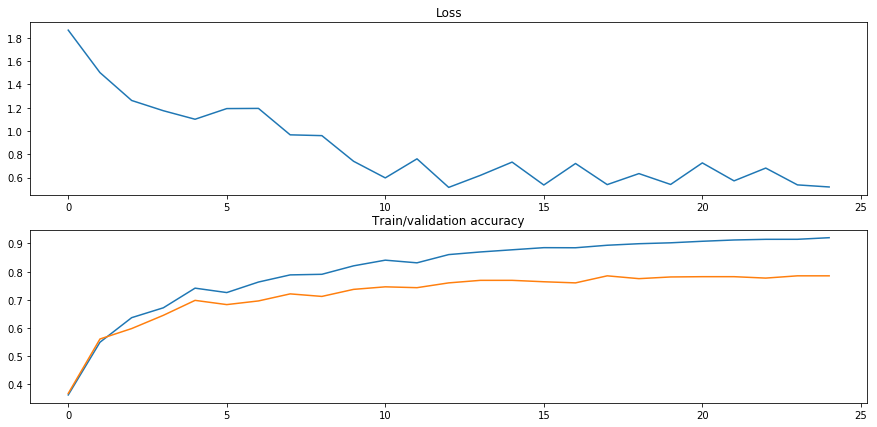

In [207]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [208]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.745000
